In [1]:
# Evaluating the Predictive Power of Personal vs Financial Feature Subsets
## Rule-Based AI for Credit Risk Classification (German Credit-style)

# This notebook compares three rule-based configurations on the **same dataset**:
# 1. **All features** (incl. Sex) – academic-only, optionally uses a small, data-driven weight for Sex
# 2. **Personal subset** – Age, Sex, Job, Housing
# 3. **Financial subset** – Saving accounts, Checking account, Credit amount, Duration, Purpose

# **Outputs**
# - Per-scenario predictions and confusion matrices (counts and normalized)
# - A summary comparison table and an accuracy bar chart

# > ⚠️ For academic comparison only. Do **not** use the `Sex` rule in real credit decisions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Any, Dict, List, Tuple
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from pathlib import Path

# ===== Paths & general settings =====
DATA_CSV = "training_data.csv"   # change to "dataset.csv" if needed
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)

# Plot look
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120

# ===== Rule threshold =====
BAD_THRESHOLD = 3  # score >= 3 => predict 'bad', else 'good'

# ===== Scenario definitions =====
# Toggle sensitive handling for each scenario:
#   'ignore'      -> Sex contributes 0 points (recommended beyond academic work)
#   'data_driven' -> Small +/-1 based on observed label rates (academic-only)
SCENARIOS = [
    {
        "name": "all_features",
        "features": ["Age","Sex","Job","Housing","Saving accounts","Checking account","Credit amount","Duration","Purpose"],
        "sensitive_mode": "data_driven"    # academic only
    },
    {
        "name": "personal",
        "features": ["Age","Sex","Job","Housing"],
        "sensitive_mode": "data_driven"    # set to 'ignore' if you prefer
    },
    {
        "name": "financial",
        "features": ["Saving accounts","Checking account","Credit amount","Duration","Purpose"],
        "sensitive_mode": "ignore"         # no Sex here anyway
    }
]

print(f"Dataset: {DATA_CSV}")
print("Scenarios:")
for sc in SCENARIOS:
    print(" -", sc["name"], "=>", sc["features"], "| sensitive_mode:", sc["sensitive_mode"])

Dataset: training_data.csv
Scenarios:
 - all_features => ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose'] | sensitive_mode: data_driven
 - personal => ['Age', 'Sex', 'Job', 'Housing'] | sensitive_mode: data_driven
 - financial => ['Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose'] | sensitive_mode: ignore


In [3]:
df = pd.read_csv(DATA_CSV)
df.columns = [c.strip() for c in df.columns]

# Clean string columns
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].astype(str).str.strip()

# Optional: unify empty strings to NaN
df = df.replace({"": np.nan, "nan": np.nan, "None": np.nan})

print(df.head(3))
print("\nColumns:", df.columns.tolist())
if "Risk" in df.columns:
    print("\nLabel distribution:\n", df["Risk"].str.lower().value_counts())
else:
    print("\nNo 'Risk' column found. Evaluation will be skipped.")

     ID  Age     Sex  Job Housing Saving accounts Checking account  \
0  1122   33    male    1    rent          little         moderate   
1    49   48    male    2     own             NaN              NaN   
2   156   39  female    1     own             NaN         moderate   

   Credit amount  Duration    Purpose  Risk  
0           2384        36    repairs   bad  
1           5190        27    repairs  good  
2            932         6  education  good  

Columns: ['ID', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk']

Label distribution:
 Risk
bad     560
good    560
Name: count, dtype: int64


In [4]:
@dataclass
class RuleResult:
    feature: str
    value: Any
    points: int
    rationale: str

def _norm_text(x):
    return (str(x).strip().lower()) if pd.notna(x) else ""

def _norm_purpose(p):
    key = _norm_text(p)
    # Lowercasing turns "radio/TV" -> "radio/tv"
    return key

class RuleBasedCreditScorer:
    def __init__(self, feature_set: List[str], bad_threshold: int = 3,
                 sensitive_mode: str = "ignore", sex_weight_map: Dict[str, int] = None):
        """
        feature_set: list of enabled features
        sensitive_mode: 'ignore' or 'data_driven'
        sex_weight_map: optional {'male': +1/0/-1, 'female': +1/0/-1} used when sensitive_mode='data_driven'
        """
        self.feature_set = set(feature_set)
        self.bad_threshold = bad_threshold
        self.sensitive_mode = sensitive_mode
        self.sex_weight_map = sex_weight_map or {}

    # ----- individual rules -----
    def _points_age(self, age):
        if "Age" not in self.feature_set: return RuleResult("Age", age, 0, "Disabled")
        age = float(age)
        if age < 25:   return RuleResult("Age", age, 2, "Very young (<25)")
        if age >= 60:  return RuleResult("Age", age, 1, "Older (>=60)")
        return RuleResult("Age", age, 0, "Prime working age")

    def _points_sex(self, sex):
        if "Sex" not in self.feature_set: return RuleResult("Sex", sex, 0, "Disabled")
        if self.sensitive_mode == "ignore":
            return RuleResult("Sex", sex, 0, "Ignored (fairness)")
        key = _norm_text(sex)
        pts = int(self.sex_weight_map.get(key, 0))
        rationale = f"Academic-only data-driven weight ({pts:+d})"
        return RuleResult("Sex", sex, pts, rationale)

    def _points_job(self, job):
        if "Job" not in self.feature_set: return RuleResult("Job", job, 0, "Disabled")
        try: j = int(job)
        except: j = None
        mapping = {0: 2, 1: 1, 2: 0, 3: -1}
        rationale = {0:"Unskilled & non-resident",1:"Unskilled & resident",2:"Skilled",3:"Highly skilled"}.get(j,"Unknown")
        return RuleResult("Job", job, mapping.get(j, 1), rationale)

    def _points_housing(self, housing):
        if "Housing" not in self.feature_set: return RuleResult("Housing", housing, 0, "Disabled")
        key = _norm_text(housing)
        pts = {"own": -1, "free": 0, "rent": 1}.get(key, 0)
        return RuleResult("Housing", housing, pts, "Own(-1) Free(0) Rent(+1)")

    def _points_savings(self, savings):
        if "Saving accounts" not in self.feature_set: return RuleResult("Saving accounts", savings, 0, "Disabled")
        key = _norm_text(savings)
        mapping = {"little": 2, "moderate": 1, "quite rich": -1, "rich": -2}
        if key == "":     return RuleResult("Saving accounts", savings, 1, "Missing savings")
        if key in mapping:
            rationale = {"little":"Low", "moderate":"Some", "quite rich":"Strong", "rich":"Very strong"}[key] + " savings"
            return RuleResult("Saving accounts", savings, mapping[key], rationale)
        return RuleResult("Saving accounts", savings, 0, "Unknown savings")

    def _points_checking(self, val):
        if "Checking account" not in self.feature_set: return RuleResult("Checking account", val, 0, "Disabled")
        # Try numeric DM
        try:
            x = float(val)
            if x < 200:    return RuleResult("Checking account", val, 2, "<200 DM")
            if x < 500:    return RuleResult("Checking account", val, 1, "200–<500 DM")
            if x < 1000:   return RuleResult("Checking account", val, 0, "500–<1000 DM")
            return RuleResult("Checking account", val, -1, ">=1000 DM")
        except:
            pass
        # Categorical fallback
        key = _norm_text(val)
        cat_map = {"little": 2, "moderate": 1, "rich": -1}
        if key == "":     return RuleResult("Checking account", val, 1, "Missing/unknown")
        if key in cat_map:
            reason = {"little":"Low", "moderate":"Moderate", "rich":"High"}[key] + " checking balance"
            return RuleResult("Checking account", val, cat_map[key], reason)
        return RuleResult("Checking account", val, 1, "Unrecognized (unknown)")

    def _points_credit_amount(self, amount):
        if "Credit amount" not in self.feature_set: return RuleResult("Credit amount", amount, 0, "Disabled")
        amount = float(amount)
        if amount < 2000:   return RuleResult("Credit amount", amount, -1, "<2,000 DM")
        if amount < 5000:   return RuleResult("Credit amount", amount, 0, "2,000–<5,000 DM")
        if amount < 10000:  return RuleResult("Credit amount", amount, 1, "5,000–<10,000 DM")
        return RuleResult("Credit amount", amount, 2, ">=10,000 DM")

    def _points_duration(self, months):
        if "Duration" not in self.feature_set: return RuleResult("Duration", months, 0, "Disabled")
        m = int(float(months))
        if m < 12:   return RuleResult("Duration", m, -1, "<12 mo")
        if m < 24:   return RuleResult("Duration", m, 0, "12–<24 mo")
        if m < 48:   return RuleResult("Duration", m, 1, "24–<48 mo")
        return RuleResult("Duration", m, 2, ">=48 mo")

    def _points_purpose(self, purpose):
        if "Purpose" not in self.feature_set: return RuleResult("Purpose", purpose, 0, "Disabled")
        key = _norm_purpose(purpose)
        mapping = {
            "education": -1, "car": 0, "repairs": 0,
            "furniture/equipment": 1, "radio/tv": 1, "domestic appliances": 1,
            "vacation/others": 1, "business": 2
        }
        pts = mapping.get(key, 0)
        return RuleResult("Purpose", purpose, pts, "Purpose risk weighting")

    def _points_burden(self, amount, duration):
        # Derived feature (always applied if both base fields are enabled)
        if not (("Credit amount" in self.feature_set) and ("Duration" in self.feature_set)):
            return RuleResult("Credit-to-Duration", None, 0, "Disabled")
        m = max(1, int(float(duration)))
        cdr = float(amount) / m
        if cdr < 200:   return RuleResult("Credit-to-Duration", round(cdr,2), -1, "Low monthly burden")
        if cdr < 400:   return RuleResult("Credit-to-Duration", round(cdr,2),  0, "Moderate monthly burden")
        if cdr < 800:   return RuleResult("Credit-to-Duration", round(cdr,2),  1, "Elevated monthly burden")
        return RuleResult("Credit-to-Duration", round(cdr,2), 2, "High monthly burden")

    # ----- scoring & prediction -----
    def score_record(self, rec: Dict[str, Any]) -> Tuple[int, List[RuleResult]]:
        rr: List[RuleResult] = []
        rr.append(self._points_age(rec.get("Age")))
        rr.append(self._points_sex(rec.get("Sex")))
        rr.append(self._points_job(rec.get("Job")))
        rr.append(self._points_housing(rec.get("Housing")))
        rr.append(self._points_savings(rec.get("Saving accounts")))
        rr.append(self._points_checking(rec.get("Checking account")))
        rr.append(self._points_credit_amount(rec.get("Credit amount")))
        rr.append(self._points_duration(rec.get("Duration")))
        rr.append(self._points_purpose(rec.get("Purpose")))
        rr.append(self._points_burden(rec.get("Credit amount"), rec.get("Duration")))

        total = sum(r.points for r in rr)
        return total, rr

    def predict_one(self, rec: Dict[str, Any]) -> Dict[str, Any]:
        total, rr = self.score_record(rec)
        label = "bad" if total >= self.bad_threshold else "good"
        # top reasons by absolute contribution
        top = sorted([r for r in rr if r.points != 0], key=lambda x: abs(x.points), reverse=True)[:5]
        return {
            "PredictedRisk": label,
            "TotalScore": total,
            "TopReasons": [{"feature": t.feature, "value": t.value, "points": t.points, "why": t.rationale} for t in top]
        }

In [5]:
def build_sex_weight_map_for_dataset(df_labels: pd.DataFrame, min_gap: float = 0.05) -> Dict[str, int]:
    """
    Returns a dict like {'male': +1, 'female': -1} when the gap in bad-rate
    is >= min_gap (5% by default). Otherwise returns zeros.
    Academic-only helper to let 'Sex' influence the score slightly.
    """
    out = {"male": 0, "female": 0}
    if "Sex" not in df_labels or "Risk" not in df_labels:
        return out

    tmp = df_labels.copy()
    tmp["Sex"]  = tmp["Sex"].astype(str).str.strip().str.lower()
    tmp["Risk"] = tmp["Risk"].astype(str).str.strip().str.lower()

    grp = tmp.groupby("Sex")["Risk"].apply(lambda s: (s == "bad").mean())
    if not {"male","female"}.issubset(grp.index):
        return out

    male_bad = grp["male"]
    fem_bad  = grp["female"]
    gap = male_bad - fem_bad

    if abs(gap) >= min_gap:
        # Penalize group with higher observed bad-rate by +1, give -1 to the other
        if gap > 0:     # males worse
            out = {"male": +1, "female": -1}
        else:           # females worse
            out = {"male": -1, "female": +1}
    return out

sex_weight_map_preview = build_sex_weight_map_for_dataset(df)
sex_weight_map_preview

{'male': -1, 'female': 1}


=== all_features ===
features: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']
sensitive_mode: data_driven | sex_map: {'male': -1, 'female': 1}
Accuracy: 0.6696
Confusion matrix:
 [[420 140]
 [230 330]]

Classification report:
               precision    recall  f1-score   support

        good       0.65      0.75      0.69       560
         bad       0.70      0.59      0.64       560

    accuracy                           0.67      1120
   macro avg       0.67      0.67      0.67      1120
weighted avg       0.67      0.67      0.67      1120



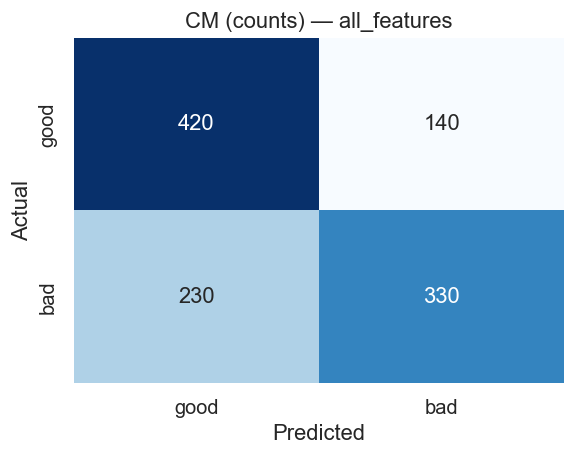

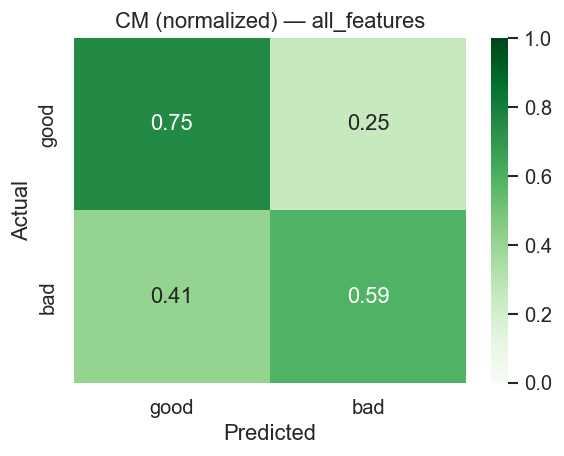


=== personal ===
features: ['Age', 'Sex', 'Job', 'Housing']
sensitive_mode: data_driven | sex_map: {'male': -1, 'female': 1}
Accuracy: 0.5321
Confusion matrix:
 [[526  34]
 [490  70]]

Classification report:
               precision    recall  f1-score   support

        good       0.52      0.94      0.67       560
         bad       0.67      0.12      0.21       560

    accuracy                           0.53      1120
   macro avg       0.60      0.53      0.44      1120
weighted avg       0.60      0.53      0.44      1120



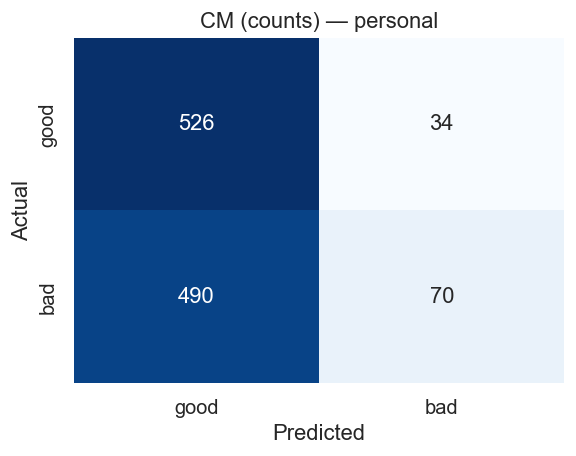

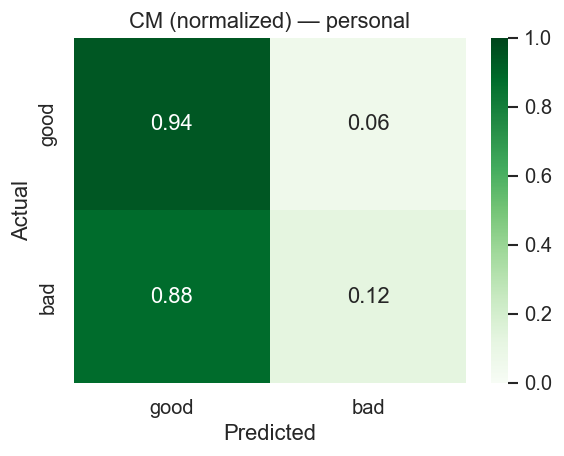


=== financial ===
features: ['Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']
sensitive_mode: ignore | sex_map: {'male': 0, 'female': 0}
Accuracy: 0.6241
Confusion matrix:
 [[388 172]
 [249 311]]

Classification report:
               precision    recall  f1-score   support

        good       0.61      0.69      0.65       560
         bad       0.64      0.56      0.60       560

    accuracy                           0.62      1120
   macro avg       0.63      0.62      0.62      1120
weighted avg       0.63      0.62      0.62      1120



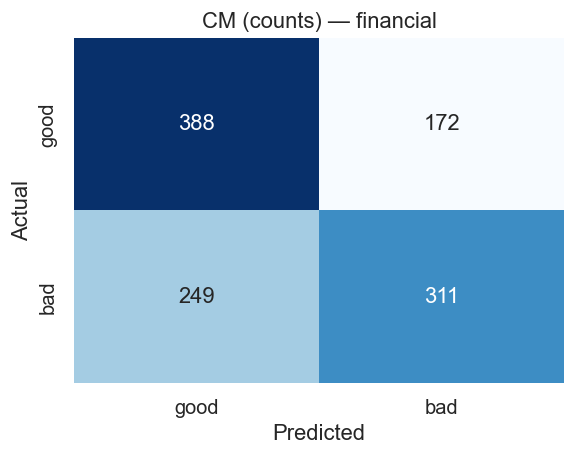

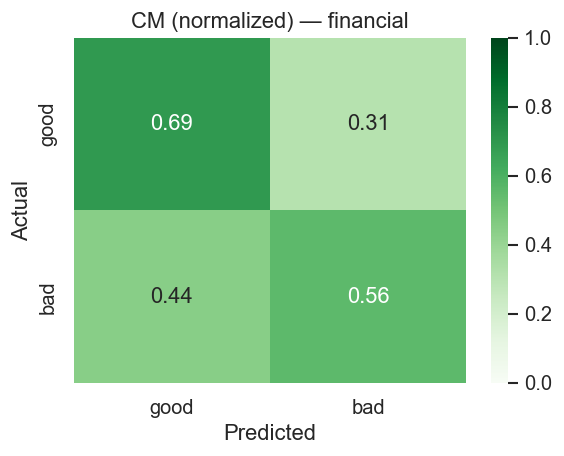

,scenario,features_used,sensitive_mode,sex_map,accuracy,precision_good,recall_good,f1_good,support_good,precision_bad,recall_bad,f1_bad,support_bad,cm_counts_png,cm_norm_png,predictions_csv
0,all_features,"Age, Sex, Job, Housing, Saving accounts, Check...",data_driven,"{'male': -1, 'female': 1}",0.669643,0.646154,0.750000,0.694215,560,0.702128,0.589286,0.640777,560,artifacts\cm_counts_all_features.png,artifacts\cm_norm_all_features.png,artifacts\predictions_all_features.csv
2,financial,"Saving accounts, Checking account, Credit amou...",ignore,"{'male': 0, 'female': 0}",0.624107,0.609105,0.692857,0.648287,560,0.643892,0.555357,0.596357,560,artifacts\cm_counts_financial.png,artifacts\cm_norm_financial.png,artifacts\predictions_financial.csv
1,personal,"Age, Sex, Job, Housing",data_driven,"{'male': -1, 'female': 1}",0.532143,0.517717,0.939286,0.667513,560,0.673077,0.125000,0.210843,560,artifacts\cm_counts_personal.png,artifacts\cm_norm_personal.png,artifacts\predictions_personal.csv


In [6]:
results_summary = []
all_predictions = {}  # scenario_name -> predictions DataFrame (for optional deeper analysis)

for sc in SCENARIOS:
    name = sc["name"]
    feats = sc["features"]
    sensitive_mode = sc["sensitive_mode"]

    # Build sex map only if requested and labels available
    sex_map = {}
    if sensitive_mode == "data_driven" and "Risk" in df.columns:
        sex_map = build_sex_weight_map_for_dataset(df)
    elif sensitive_mode == "ignore":
        sex_map = {"male": 0, "female": 0}

    scorer = RuleBasedCreditScorer(feature_set=feats,
                                   bad_threshold=BAD_THRESHOLD,
                                   sensitive_mode=sensitive_mode,
                                   sex_weight_map=sex_map)

    # Predict row-wise
    preds = []
    reasons1, reasons2, reasons3 = [], [], []
    scores = []
    for _, row in df.iterrows():
        out = scorer.predict_one(row.to_dict())
        preds.append(out["PredictedRisk"])
        scores.append(out["TotalScore"])
        tr = out["TopReasons"]
        reasons1.append(f"{tr[0]['feature']}({tr[0]['points']})" if len(tr)>0 else "")
        reasons2.append(f"{tr[1]['feature']}({tr[1]['points']})" if len(tr)>1 else "")
        reasons3.append(f"{tr[2]['feature']}({tr[2]['points']})" if len(tr)>2 else "")

    pred_df = df.copy()
    pred_df[f"Predicted_{name}"] = pd.Series(preds, index=df.index).str.lower()
    pred_df[f"Score_{name}"]     = scores
    pred_df[f"Reason1_{name}"]   = reasons1
    pred_df[f"Reason2_{name}"]   = reasons2
    pred_df[f"Reason3_{name}"]   = reasons3

    # Save per-scenario predictions
    out_csv = ARTIFACTS_DIR / f"predictions_{name}.csv"
    pred_df.to_csv(out_csv, index=False)

    # Evaluate if Risk available
    if "Risk" in df.columns:
        y_true = df["Risk"].astype(str).str.lower().str.strip()
        y_pred = pred_df[f"Predicted_{name}"]

        labels = ["good", "bad"]
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
        acc = accuracy_score(y_true, y_pred)
        pr, rc, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=labels, zero_division=0)

        print(f"\n=== {name} ===")
        print(f"features: {feats}")
        print(f"sensitive_mode: {sensitive_mode} | sex_map: {sex_map}")
        print(f"Accuracy: {acc:.4f}")
        print("Confusion matrix:\n", cm)
        print("\nClassification report:\n", classification_report(y_true, y_pred, labels=labels))

        # Plot & save CMs
        fig, ax = plt.subplots(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_xlabel('Predicted'); ax.set_ylabel('Actual'); ax.set_title(f'CM (counts) — {name}')
        plt.tight_layout()
        path_counts = ARTIFACTS_DIR / f"cm_counts_{name}.png"
        fig.savefig(path_counts); plt.show()

        fig2, ax2 = plt.subplots(figsize=(5,4))
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', cbar=True,
                    xticklabels=labels, yticklabels=labels, ax=ax2, vmin=0, vmax=1)
        ax2.set_xlabel('Predicted'); ax2.set_ylabel('Actual'); ax2.set_title(f'CM (normalized) — {name}')
        plt.tight_layout()
        path_norm = ARTIFACTS_DIR / f"cm_norm_{name}.png"
        fig2.savefig(path_norm); plt.show()

        # Store scenario-metrics summary
        results_summary.append({
            "scenario": name,
            "features_used": ", ".join(feats),
            "sensitive_mode": sensitive_mode,
            "sex_map": sex_map,
            "accuracy": acc,
            "precision_good": pr[0], "recall_good": rc[0], "f1_good": f1[0], "support_good": sup[0],
            "precision_bad":  pr[1], "recall_bad":  rc[1], "f1_bad":  f1[1], "support_bad":  sup[1],
            "cm_counts_png": str(path_counts),
            "cm_norm_png": str(path_norm),
            "predictions_csv": str(out_csv)
        })

    all_predictions[name] = pred_df

# Summary table
if results_summary:
    summary_df = pd.DataFrame(results_summary)
    display(summary_df.sort_values("accuracy", ascending=False))
    summary_df.to_csv(ARTIFACTS_DIR / "scenario_summary.csv", index=False)

C:\Users\Jared\AppData\Local\Temp\ipykernel_15860\697351182.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x="scenario", y="accuracy", palette="viridis")


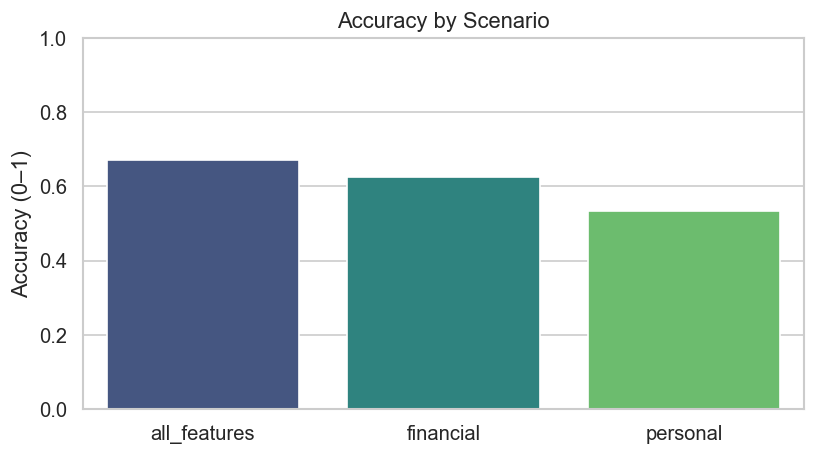

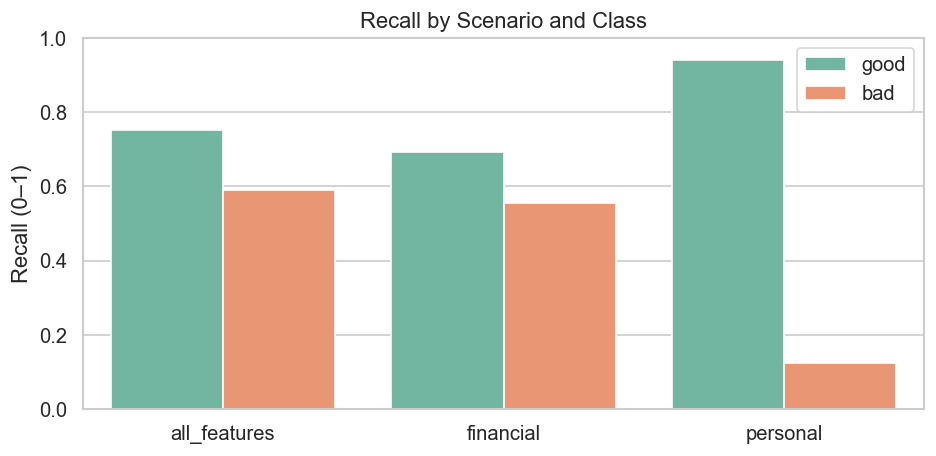

In [7]:
if results_summary:
    plot_df = pd.DataFrame(results_summary).sort_values("accuracy", ascending=False)
    plt.figure(figsize=(7,4))
    sns.barplot(data=plot_df, x="scenario", y="accuracy", palette="viridis")
    plt.ylim(0,1)
    plt.title("Accuracy by Scenario")
    plt.ylabel("Accuracy (0–1)")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

    # Optional: compare recall by class (good/bad)
    melted = pd.melt(plot_df[["scenario","recall_good","recall_bad"]],
                     id_vars="scenario", var_name="metric", value_name="recall")
    melted["class"] = melted["metric"].str.replace("recall_", "", regex=False)
    plt.figure(figsize=(8,4))
    sns.barplot(data=melted, x="scenario", y="recall", hue="class", palette="Set2")
    plt.ylim(0,1)
    plt.title("Recall by Scenario and Class")
    plt.ylabel("Recall (0–1)")
    plt.xlabel("")
    plt.legend(title="")
    plt.tight_layout()
    plt.show()

In [8]:
# Academic-only: see how each scenario performs within male vs female groups
if "Risk" in df.columns and "Sex" in df.columns:
    sex_groups = df["Sex"].astype(str).str.lower().unique()
    for sc in SCENARIOS:
        name = sc["name"]
        pred_col = f"Predicted_{name}"
        if pred_col not in all_predictions[name].columns:
            continue
        print(f"\n--- Subgroup metrics for scenario: {name} ---")
        for g in sex_groups:
            mask = df["Sex"].astype(str).str.lower() == g
            if mask.sum() == 0: continue
            y_true = df.loc[mask, "Risk"].astype(str).str.lower()
            y_pred = all_predictions[name].loc[mask, pred_col].astype(str).str.lower()
            acc = accuracy_score(y_true, y_pred)
            cm  = confusion_matrix(y_true, y_pred, labels=["good","bad"])
            print(f"Sex={g:7s} | n={mask.sum():4d} | Acc={acc:.3f} | CM={cm.tolist()}")


--- Subgroup metrics for scenario: all_features ---
Sex=male    | n= 748 | Acc=0.675 | CM=[[332, 65], [178, 173]]
Sex=female  | n= 372 | Acc=0.659 | CM=[[88, 75], [52, 157]]

--- Subgroup metrics for scenario: personal ---
Sex=male    | n= 748 | Acc=0.536 | CM=[[393, 4], [343, 8]]
Sex=female  | n= 372 | Acc=0.524 | CM=[[133, 30], [147, 62]]

--- Subgroup metrics for scenario: financial ---
Sex=male    | n= 748 | Acc=0.643 | CM=[[274, 123], [144, 207]]
Sex=female  | n= 372 | Acc=0.586 | CM=[[114, 49], [105, 104]]
